<a href="https://colab.research.google.com/github/erika0915/artificial-intelligence/blob/main/mlp/04_activation_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

활성화 함수 비교 실험
- 동일 구조에서 Sigmoid, Tanh, ReLU 비교
- 은닉층 1개, 32개 유닛
- 옵티마이저 : SGD (lr = 0.1)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.90MB/s]



 활성화 함수: SIGMOID
[ 1] Loss: 0.5971
[ 2] Loss: 0.2768
[ 3] Loss: 0.2278
[ 4] Loss: 0.1999
[ 5] Loss: 0.1814
[ 6] Loss: 0.1668
[ 7] Loss: 0.1556
[ 8] Loss: 0.1461
[ 9] Loss: 0.1380
[10] Loss: 0.1313
 총 학습 시간: 163.48초
Test Loss: 0.1468 | Accuracy: 95.67%

 활성화 함수: TANH
[ 1] Loss: 0.3356
[ 2] Loss: 0.1941
[ 3] Loss: 0.1591
[ 4] Loss: 0.1393
[ 5] Loss: 0.1252
[ 6] Loss: 0.1152
[ 7] Loss: 0.1063
[ 8] Loss: 0.0993
[ 9] Loss: 0.0936
[10] Loss: 0.0875
 총 학습 시간: 158.32초
Test Loss: 0.1304 | Accuracy: 96.05%

 활성화 함수: RELU
[ 1] Loss: 0.2973
[ 2] Loss: 0.1530
[ 3] Loss: 0.1206
[ 4] Loss: 0.1039
[ 5] Loss: 0.0908
[ 6] Loss: 0.0828
[ 7] Loss: 0.0761
[ 8] Loss: 0.0699
[ 9] Loss: 0.0646
[10] Loss: 0.0604
 총 학습 시간: 158.62초
Test Loss: 0.1127 | Accuracy: 96.84%


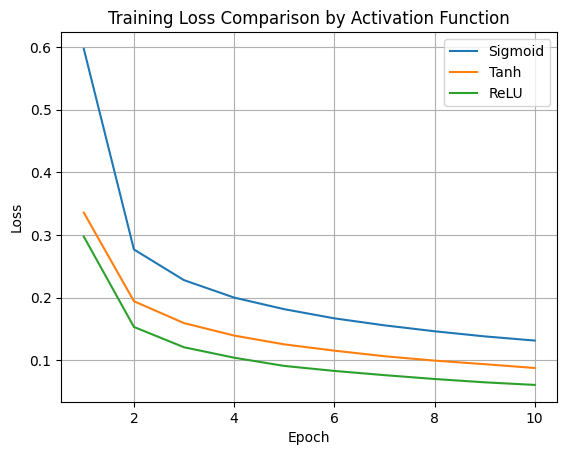

In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. 데이터 전처리 & 로더
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=1000, shuffle=False)


# 2. MLP 모델 정의 (활성화 함수 선택 가능)
class MLP(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 32)
        self.activation = activation_fn
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# 3. 학습 설명
def train_and_evaluate(activation_name):
    print(f'\n 활성화 함수: {activation_name.upper()}')

    # 활성화 함수 매핑
    activations = {
        'sigmoid': nn.Sigmoid(),
        'tanh': nn.Tanh(),
        'relu': nn.ReLU()
    }

    model = MLP(activation_fn=activations[activation_name]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    epochs = 10
    loss_history = []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(trainloader.dataset)
        loss_history.append(epoch_loss)
        print(f"[{epoch+1:2d}] Loss: {epoch_loss:.4f}")

    total_time = time.time() - start_time
    print(f" 총 학습 시간: {total_time:.2f}초")

    # 테스트 평가
    model.eval()
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    test_loss /= len(testloader.dataset)
    accuracy = correct / len(testloader.dataset) * 100
    print(f"Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.2f}%")

    return loss_history, test_loss, accuracy

# 4. 학습
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_sigmoid, loss_tanh, loss_relu = [], [], []
loss_sigmoid, _, _ = train_and_evaluate('sigmoid')
loss_tanh, _, _ = train_and_evaluate('tanh')
loss_relu, _, _ = train_and_evaluate('relu')

# 6. 시각화
plt.figure()
plt.plot(range(1, 11), loss_sigmoid, label='Sigmoid')
plt.plot(range(1, 11), loss_tanh, label='Tanh')
plt.plot(range(1, 11), loss_relu, label='ReLU')
plt.title('Training Loss Comparison by Activation Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
